# import

In [104]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
import nltk
import networkx as nx

In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
not_needed = ['AU', 'BA', 'BF', 'CA', 'GP', 'BE', 'SE', 'BS', 'CT', 'CY' ,'CL', 'SP', 'HO', 'RP', 'EM', 
              'RI', 'OI', 'FX', 'TC', 'U1', 'U2', 'PI', 'PA', 'SN', 'EI', 'BN', 'ID', 'J9', 'VL', 'IS', 
              'SI', 'PN', 'SU', 'MA', 'BP', 'EP', 'AR', 'DI', 'D2', 'EA', 'GA', 'PM', 'UT', 'OA', 'HP',
              'HC', 'DA'] 

def to_df(directory, not_needed=not_needed):
    file_names = os.listdir(directory)
    data_frames = [pd.read_csv(directory+file_name, sep='\t',  engine='c', index_col=False, quotechar='^') for file_name in file_names] 
    print('Checking duplicates...')
    all_clear = True
    for i in range(len(data_frames)):
        for j in range(i+1, len(data_frames)):
            if str(data_frames[i].iloc[0,:]) == str(data_frames[j].iloc[0,:]):
                print('Duplicated dataframes:' + str(file_names[i]) +', '+str(file_names[j]))
                all_clear = False
    if all_clear:
        print('All clear')
    else:
        print('Check the files')
        
    concatenated = pd.concat(data_frames, ignore_index=True)
    if not_needed:
        concatenated.drop(columns=not_needed, inplace=True)
    concatenated.drop_duplicates(inplace=True)
    return concatenated

In [107]:
example_df  = pd.read_csv('/content/drive/MyDrive/data/savedrecs.txt', sep='\t',  engine='c', index_col=False, quotechar='^')
example_df.to_excel('ex_ex.xlsx')

In [108]:
data = to_df('/content/drive/MyDrive/data/')

Checking duplicates...
All clear


In [109]:
data.to_excel("data.xlsx")

In [110]:
data = pd.read_excel('data.xlsx', usecols=range(1,30))

In [111]:
mon = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
data.PD = data.PD.str[:3].str.capitalize()
data_w_date = data[data.PD.isin(mon)].copy()
data_w_date.PD = data_w_date.PD.apply(lambda x: datetime.strptime(x,'%b').strftime('2020-%m'))

# Document type

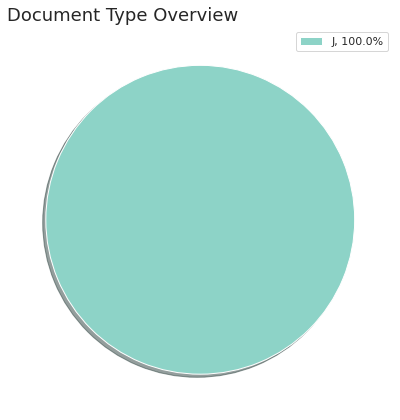

In [112]:
data_doc = data.PT.dropna().str.split(';').apply(lambda x: x[0]).value_counts().rename_axis('DocType').reset_index(name='Count')

with plt.style.context({'axes.prop_cycle' : plt.cycler('color', plt.cm.Set3.colors)}):
    fig1, ax1 = plt.subplots(figsize=(6, 6))
    labels = data_doc.iloc[:,0]
    size = data_doc.iloc[:,1]/data_doc.iloc[:,1].sum()*100
    ax1.pie(data_doc.iloc[:,1], startangle=90, shadow=True)
    ax1.legend(labels =['%s, %1.1f%%' % (l,s) for l,s in zip(labels,size)])
    ax1.set_title('Document Type Overview', fontsize=18, loc='left')
    plt.tight_layout()
    plt.savefig('doc_type.jpg')
    plt.show()


# By language

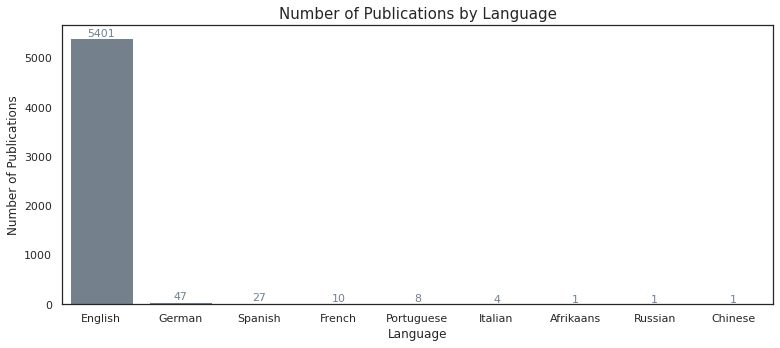

In [113]:
data_lang = data.LA.dropna().value_counts().rename_axis('Language').reset_index(name='Count')[0:10]

plt.figure(figsize=(11,5))
g = sns.barplot(x=data_lang.Language, y=data_lang.Count, color='slategrey')
plt.xlabel('Language',fontsize=12)
plt.ylabel('Number of Publications',fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
for p in g.patches:
             g.annotate("%1.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', fontsize=11, color='slategrey',xytext=(0, 5), textcoords='offset points')
plt.title('Number of Publications by Language', fontsize=15)
plt.tight_layout()
plt.savefig('doc_lang.jpg')
plt.show()

# By source

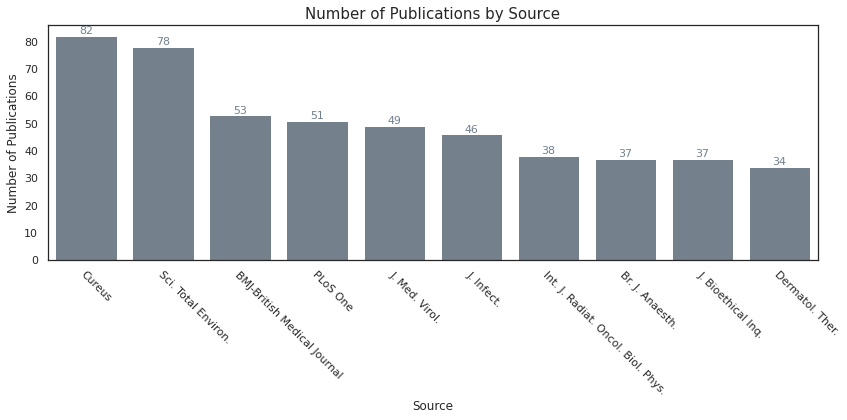

In [114]:
data_source = data.JI.dropna().value_counts().rename_axis('Title').reset_index(name='Count')[0:10]

plt.figure(figsize=(12,6))
g=sns.barplot(x=data_source.Title, y=data_source.Count, color='slategrey')
plt.xlabel('Source',fontsize=12)
plt.ylabel('Number of Publications',fontsize=12)
plt.xticks(fontsize=11, rotation = -45, ha='left', rotation_mode='anchor')
plt.yticks(fontsize=11)
for p in g.patches:
             g.annotate("%1.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', fontsize=11, color='slategrey',xytext=(0, 5), textcoords='offset points')
plt.title('Number of Publications by Source', fontsize=15)
plt.tight_layout()
plt.savefig('doc_source.jpg')
plt.show()

# Number of pages


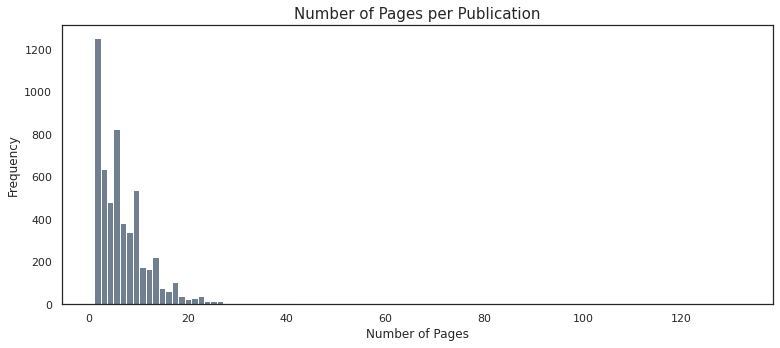

In [115]:
data_page = data.PG.dropna()

plt.figure(figsize=(11,5))
plt.hist(x=data_page, color='slategrey', bins=100)
plt.xlabel('Number of Pages',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title('Number of Pages per Publication', fontsize=15)
plt.tight_layout()
plt.savefig('doc_page.jpg')
plt.show()

# By institution

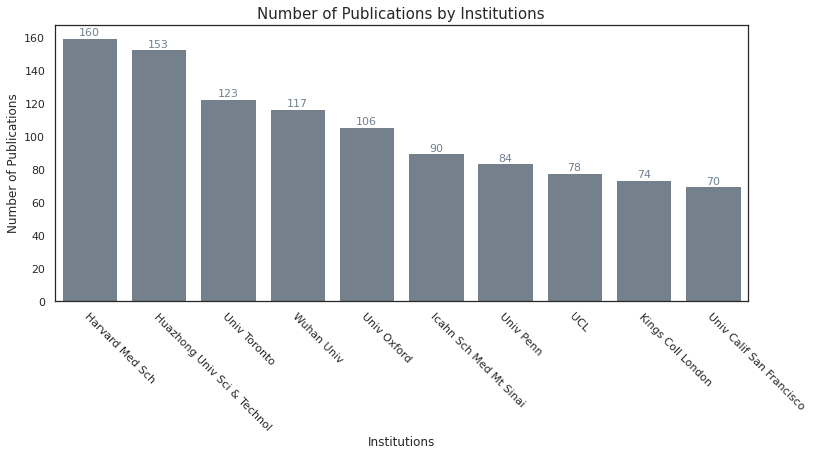

In [116]:
data_inst = data[['C1']].dropna()
data_inst.C1= data_inst.C1.apply(lambda x: re.findall(r"\] (.*?)\,", x))
data_inst_all = data_inst.explode('C1').C1.value_counts().rename_axis('Institutions').reset_index(name='Count')[0:10]


plt.figure(figsize=(11.5,6.5))
g=sns.barplot(x=data_inst_all.Institutions, y=data_inst_all.Count, color='slategrey')
plt.xlabel('Institutions',fontsize=12)
plt.ylabel('Number of Publications',fontsize=12)
plt.xticks(fontsize=11, rotation = -45, ha='left', rotation_mode='anchor')
plt.yticks(fontsize=11)
for p in g.patches:
             g.annotate("%1.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', fontsize=11, color='slategrey',xytext=(0, 5), textcoords='offset points')

plt.title('Number of Publications by Institutions', fontsize=15)
plt.tight_layout()
plt.savefig('doc_inst.jpg')
plt.show()

In [ ]:
set([i for j in data_inst.C1 for i in j])

# By country

In [118]:
data_country = data[['C1']].dropna()
data_country.C1 = data_country.C1.apply(lambda x: re.sub(r"\[(.*?)\] ", "", x).split('; ')).to_list()

data_country['country']=[list(set(i)) for i in [[j.split(', ')[-1] for j in i] for i in data_country.C1]] 

def replace(string):
  if 'USA' in string:
    return 'USA'
  elif 'North Ireland' in string:
    return 'UK'
  elif 'Wales' in string:
    return 'UK'
  elif 'Scotland' in string:
    return 'UK'
  elif 'England' in string:
    return 'UK'
  elif 'P. R. China' in string:
    return 'China'
  elif 'Peoples R China' in string:
    return 'China'

  else:
    return string
data_country['replace_1'] = [[replace(i) for i in j] for j in data_country['country']]
data_country['replace'] = [list(set(i)) for i in data_country['replace_1']]

data_country['replace']

0       [UK, South Africa, Jamaica, Cameroon, Kenya]
1                                          [UK, USA]
2                                            [Ghana]
3                                              [USA]
4                                     [South Africa]
                            ...                     
5490                                     [China, UK]
5491                                         [Italy]
5492                              [China, Australia]
5498                                           [USA]
5499                                            [UK]
Name: replace, Length: 5270, dtype: object

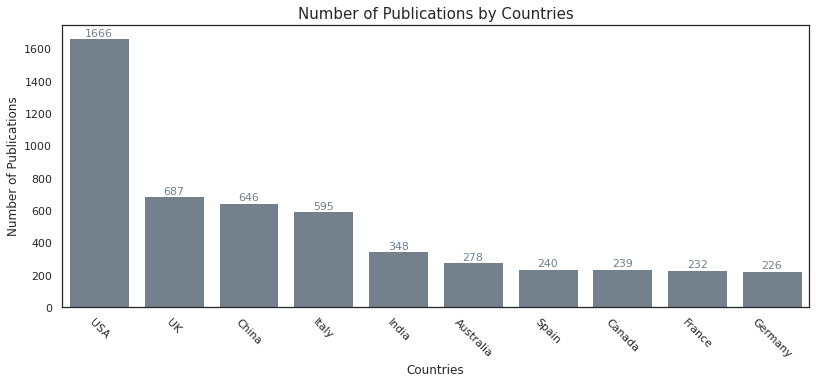

In [119]:
data_country_all = data_country.explode('replace')['replace'].value_counts().rename_axis('Countries').reset_index(name='Count')
data_country_10 = data_country_all[0:10]


plt.figure(figsize=(11.5,5.5))
g=sns.barplot(x=data_country_10.Countries, y=data_country_10.Count, color='slategrey')
plt.xlabel('Countries',fontsize=12)
plt.ylabel('Number of Publications',fontsize=12)
plt.xticks(fontsize=11, rotation = -45)
plt.yticks(fontsize=11)
for p in g.patches:
             g.annotate("%1.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', fontsize=11, color='slategrey',xytext=(0, 5), textcoords='offset points')

plt.title('Number of Publications by Countries', fontsize=15)
plt.tight_layout()
plt.savefig('doc_country.jpg')
plt.show()

In [120]:
data_country_all.Countries.unique()

array(['USA', 'UK', 'China', 'Italy', 'India', 'Australia', 'Spain',
       'Canada', 'France', 'Germany', 'Brazil', 'Netherlands', 'Iran',
       'Turkey', 'Japan', 'Switzerland', 'Singapore', 'Belgium',
       'South Korea', 'Sweden', 'Saudi Arabia', 'Austria', 'Ireland',
       'Egypt', 'Greece', 'South Africa', 'Pakistan', 'Israel', 'Taiwan',
       'Portugal', 'Mexico', 'Poland', 'Denmark', 'Norway', 'Russia',
       'New Zealand', 'Malaysia', 'Bangladesh', 'Nigeria', 'Colombia',
       'Chile', 'Argentina', 'Vietnam', 'Indonesia', 'Thailand',
       'Finland', 'Lebanon', 'U Arab Emirates', 'Jordan', 'Romania',
       'Philippines', 'Kenya', 'Morocco', 'Slovenia', 'Qatar', 'Iraq',
       'Peru', 'Czech Republic', 'Ghana', 'Ecuador', 'Sri Lanka',
       'Serbia', 'Croatia', 'Tunisia', 'Luxembourg', 'Algeria', 'Hungary',
       'Oman', 'Kuwait', 'Nepal', 'Cyprus', 'DEM REP CONGO', 'AU',
       'Cameroon', 'Ethiopia', 'Lithuania', 'Uruguay', 'Senegal',
       'Grenada', 'Costa Rica',

In [121]:
country_distr_map=data_country_all.to_excel('country_distr_map.xlsx')

# By research area

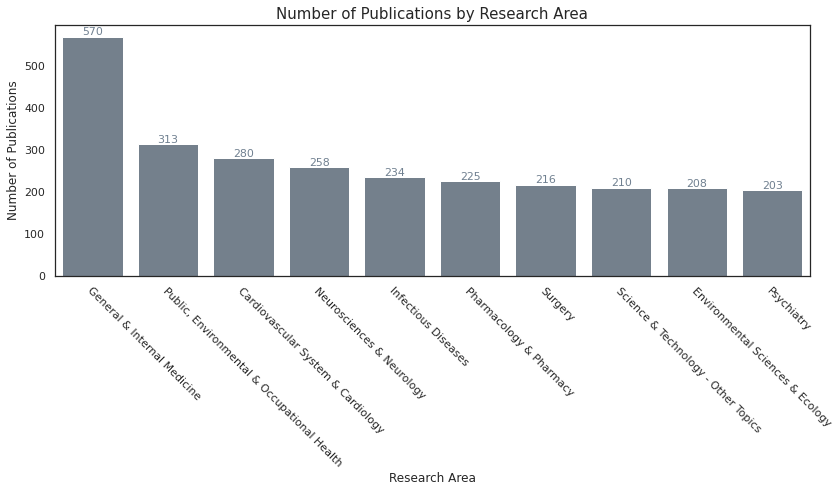

In [122]:
data_research = data[['SC']].dropna()
data_research.SC = data_research.SC.str.split('; ')
data_research_all = data_research.explode('SC').SC.value_counts().rename_axis('ResArea').reset_index(name='Count')[:10]

plt.figure(figsize=(12,7))
g=sns.barplot(x=data_research_all.ResArea, y=data_research_all.Count, color='slategrey')
plt.xlabel('Research Area',fontsize=12)
plt.ylabel('Number of Publications',fontsize=12)
plt.xticks(fontsize=11, rotation = -45, ha='left', rotation_mode='anchor')
plt.yticks(fontsize=11)
for p in g.patches:
             g.annotate("%1.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', fontsize=11, color='slategrey',xytext=(0, 5), textcoords='offset points')

plt.title('Number of Publications by Research Area', fontsize=15)
plt.tight_layout()
plt.savefig('doc_research.jpg')
plt.show()

# By author keyword

In [123]:
data_keywords=data[['DE']].dropna()
data_keywords.DE = data_keywords.DE.str.split('; ')
data_keywords_full = data_keywords.explode('DE').DE.str.lower().value_counts().rename_axis('Author Keywords').reset_index(name='Count')
data_keywords_full.head(20)


,Author Keywords,Count
0,covid-19,2236
1,sars-cov-2,733
2,coronavirus,451
3,pandemic,277
4,mortality,65
5,telemedicine,63
6,coronavirus disease 2019,62
7,covid-19 pandemic,60
8,covid,55
9,public health,54


# Author table

In [ ]:
data_author = data[['AF']].dropna()
data_author = data_author.loc[data_author.AF != '[Anonymous]']
data_author.AF = data_author.AF.str.split('; ')
data_author_all = data_author.explode('AF').AF.value_counts().rename_axis('AF').reset_index(name='Number of papers')

In [ ]:
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz 
from fuzzywuzzy import process

In [ ]:
# Wroclawski, Marcelo L. | Wroclawski, Marcelo Langer
# Valenti, Marc | Valenti, Mario | 88 ?
# Valenti, Marc | Valenti, M. | 86 ?
# Fang, Xinyu | Fang, Xin-Yu | 95
# Zhang, Chen | Zhang, Cen | 95
# Hellin, J. | Hellin, Jon | 89
# McKay, Dean | McKay, D. | 82
# Zhang, Yong | Zhang, Y. | 82 undistinguishable
# Wang, Yi | Wang, Y. | 92 undistinguishable
# Cheng, Yi | Chen, Y. | 86 undistinguishable
# Tibdewal, A. | Tibdewal, Anil | 87
#


In [ ]:
te_l = [i for j in list(data_author['AF']) for i in j]
for i in range(len(te_l)):
  for j in range(len(te_l[i+1:])):
    if (fuzz.token_sort_ratio(te_l[i],te_l[j]) > 80) & (fuzz.token_sort_ratio(te_l[i],te_l[j]) != 100):
      print(te_l[i], '|',te_l[j], '|', fuzz.token_sort_ratio(te_l[i], te_l[j]))

In [124]:
author_cited = data[['AF','Z9','SC']].dropna()
author_cited = author_cited.loc[author_cited.AF != '[Anonymous]']
author_cited.AF = author_cited.AF.str.split(';')
author_cited_all = author_cited.explode('AF').sort_values('Z9', ascending=False).drop(columns = 'SC').reset_index().drop(columns = 'index')
author_cited_all = author_cited_all[['AF', 'Z9']]
au_ci = author_cited_all.groupby('AF').sum().sort_values('Z9', ascending=False)
au_ci_1 = author_cited_all.groupby('AF').count().reset_index().rename(columns={'Z9':'Count'})
au_ci_per = pd.merge(au_ci, au_ci_1, on='AF', how='inner')
au_ci_per['Number cited per paper'] = au_ci_per['Z9']/au_ci_per['Count']
au_ci_per = au_ci_per.drop(columns=['Z9', 'Count']).sort_values('Number cited per paper', ascending=False)

author_tb = pd.merge(data_author_all, au_ci, on='AF', how='inner').dropna()
author_tb['cited per paper'] = author_tb.Z9/author_tb['Number of papers']
author_tb = author_tb[['AF', 'Z9', 'cited per paper', 'Number of papers']]
author_tb.sort_values(by=['Z9', 'cited per paper', 'Number of papers'], ascending=False).reset_index(drop=True).head(20)

,AF,Z9,cited per paper,Number of papers
0,"Grillet, Franck",52,26.000000,2
1,"Leonard-Lorant, Ian",50,25.000000,2
2,"Cai, Qingxian",43,14.333333,3
3,"Yu, Jingyou",42,10.500000,4
4,"Lax, Sigurd F.",35,17.500000,2
5,"Mahato, Susanta",34,17.000000,2
6,"Natoli, S.",33,33.000000,1
7,"Kim, Hyungjin",30,30.000000,1
8,"van Dorp, Lucy",27,27.000000,1
9,"Chandrashekar, Abishek",26,13.000000,2


# Most cited papers

In [125]:
data[['TI', 'SC', 'Z9']].dropna().sort_values('Z9', ascending=False).reset_index(drop=True).head(10)

,TI,SC,Z9
0,Acute Pulmonary Embolism Associated with COVID...,"Radiology, Nuclear Medicine & Medical Imaging",52
1,Acute Pulmonary Embolism in Patients with COVI...,"Radiology, Nuclear Medicine & Medical Imaging",50
2,COVID-19: Abnormal liver function tests,Gastroenterology & Hepatology,43
3,DNA vaccine protection against SARS-CoV-2 in r...,Science & Technology - Other Topics,42
4,Pulmonary Arterial Thrombosis in COVID-19 With...,General & Internal Medicine,35
5,Effect of lockdown amid COVID-19 pandemic on a...,Environmental Sciences & Ecology,34
6,Does SARS-Cov-2 invade the brain? Translationa...,Neurosciences & Neurology,33
7,Diagnostic Performance of CT and Reverse Trans...,"Radiology, Nuclear Medicine & Medical Imaging",30
8,Emergence of genomic diversity and recurrent m...,Infectious Diseases,27
9,Guidelines for Laboratory Diagnosis of Coronav...,Medical Laboratory Technology,26


# Number of authors per paper (-anonymous)

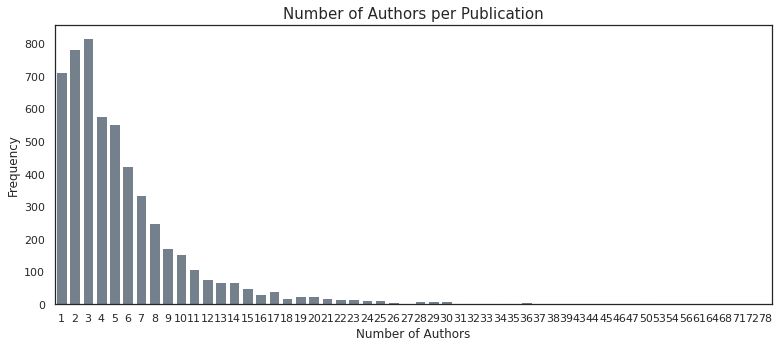

In [126]:
data_author_wo_anony = data_author.loc[data_author.AF != '[Anonymous]']
author_per_ppr = data_author_wo_anony.AF.apply(lambda x: len(x))
author_per_ppr_df = author_per_ppr.value_counts().rename_axis('Number of Authors').reset_index(name='Count').sort_values('Number of Authors')

plt.figure(figsize=(11,5))
g=sns.barplot(x=author_per_ppr_df['Number of Authors'],y=author_per_ppr_df['Count'], color='slategrey')
plt.xlabel('Number of Authors',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title('Number of Authors per Publication', fontsize=15)
plt.tight_layout()
plt.savefig('author_per_ppr.jpg')
plt.show()

# By month

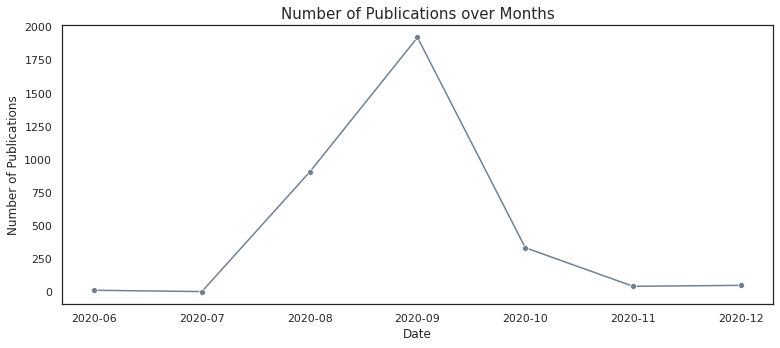

In [127]:
date_count = data_w_date.sort_values(by = 'PD').groupby('PD').size().rename_axis('Date').reset_index(name='Count')
plt.figure(figsize=(11,5))
g=sns.lineplot(x=date_count.Date, y=date_count.Count, color='slategrey', marker='o')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Number of Publications',fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title('Number of Publications over Months', fontsize=15)
plt.tight_layout()
plt.savefig('date_count.jpg')
plt.show()

# By country over month

In [128]:
country_month = data_w_date[['C1', 'PD']].dropna()
country_month.C1 = country_month.C1.apply(lambda x: re.sub(r"\[(.*?)\]", "", x).split('; ')).to_list()
country_month['country']=[list(set(i)) for i in [[j.split(', ')[-1] for j in i] for i in country_month.C1]]     
country_month['replace'] = [[replace(i) for i in j] for j in country_month['country']]
country_month['replace'] = [list(set(i)) for i in country_month['replace']]                                                 
country_month_all = country_month.explode('replace').drop(columns=['C1','country'])
country_month_all['num']=1
country_month_10 = country_month_all[country_month_all['replace'].isin(data_country_10['Countries'].to_list())].groupby(['PD','replace']).count().reset_index()


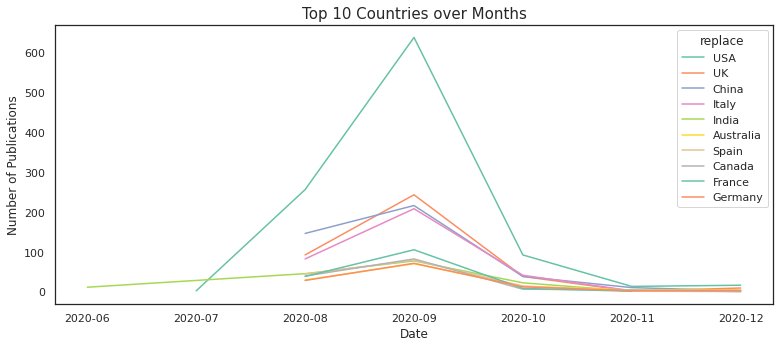

In [129]:

plt.figure(figsize=(11,5))
sns.lineplot(x=country_month_10['PD'], y=country_month_10['num'], hue=country_month_10['replace'],
            hue_order=data_country_10.Countries.to_list(),
            palette='Set2')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Number of Publications',fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title('Top 10 Countries over Months', fontsize=15)
plt.tight_layout()
plt.savefig('country_month_10.jpg')
plt.show()


# Source over month

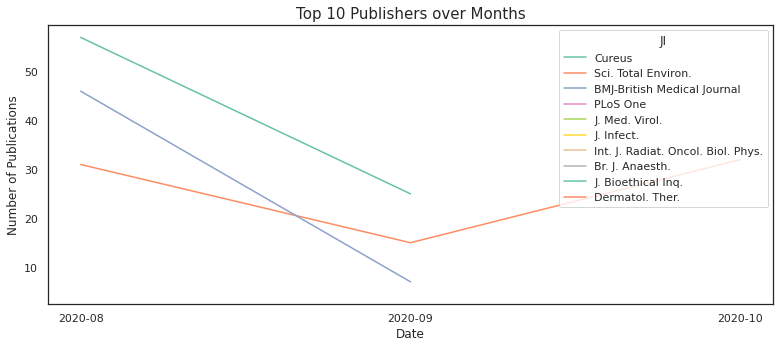

In [130]:
pub_month = data_w_date[['JI', 'PD']].dropna()
pub_month['Number']=1
pub_month_count_10 = pub_month[pub_month['JI'].isin(data_source['Title'].to_list())].groupby(['PD','JI']).count().reset_index()

plt.figure(figsize=(11,5))
sns.lineplot(x=pub_month_count_10['PD'], y=pub_month_count_10['Number'], hue=pub_month_count_10['JI'],
            hue_order=data_source['Title'].to_list(),
            palette='Set2')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Number of Publications',fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title('Top 10 Publishers over Months', fontsize=15)
plt.tight_layout()
plt.savefig('publisher_month.jpg')
plt.show()

# Research area over month

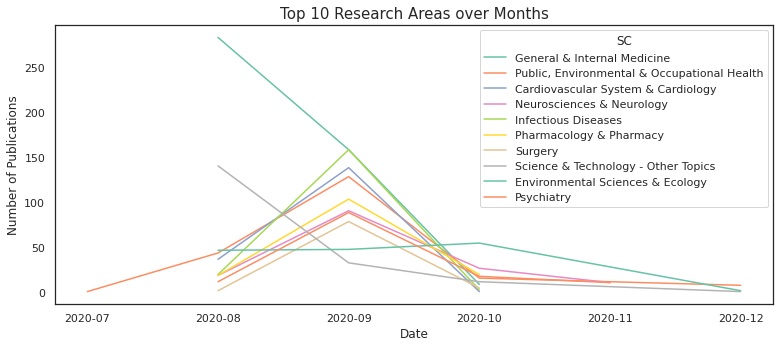

In [131]:
research_month = data_w_date[['SC','PD']].dropna()
research_month['SC'] = research_month['SC'].str.split('; ')
research_month_all = research_month.explode('SC')
research_month_all['num']=1
research_month_10 = research_month_all[research_month_all.SC.isin(data_research_all['ResArea'].to_list())].groupby(['PD','SC']).count().reset_index()

plt.figure(figsize=(11,5))
sns.lineplot(x=research_month_10['PD'], y=research_month_10['num'], 
             hue=research_month_10['SC'],
            hue_order=data_research_all['ResArea'].to_list(),
            palette='Set2')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Number of Publications',fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title('Top 10 Research Areas over Months', fontsize=15)
plt.tight_layout()
plt.savefig('research_month.jpg')
plt.show()


# Keyword viz

In [132]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [133]:
def get_full_keywords(data_selected):
    data_selected['tok_title'] = [word_tokenize(title) for title in data_selected['TI']]
    data_selected['tok_abstract'] = [word_tokenize(title) for title in data_selected['AB']]
    stop_words=set(stopwords.words("english")+list(string.punctuation)+list(string.digits))
    data_selected['text']=data_selected['tok_title']+data_selected['tok_abstract']
    
    filtered_texts=[]
    for t in data_selected['text']:
        filtered_text=[]
        for word in t:
            if word.lower() not in stop_words:
                filtered_text.append(word)
        filtered_texts.append(filtered_text)

    keywords_text = [[item.lower() for item in sublist] for sublist in filtered_texts]
    kl = [x for sub in keywords_text for x in sub]
    
    keys_dist_20 = Counter(kl)
    return keys_dist_20

In [134]:
cloud = data[['TI','AB']].dropna()
key_freq = get_full_keywords(cloud)

In [135]:
key_freq.most_common(10)

[('covid-19', 11831),
 ('patients', 5991),
 ('pandemic', 3980),
 ('disease', 2965),
 ('sars-cov-2', 2903),
 ('coronavirus', 2739),
 ('health', 2325),
 ('study', 2135),
 ('infection', 1926),
 ('clinical', 1802)]

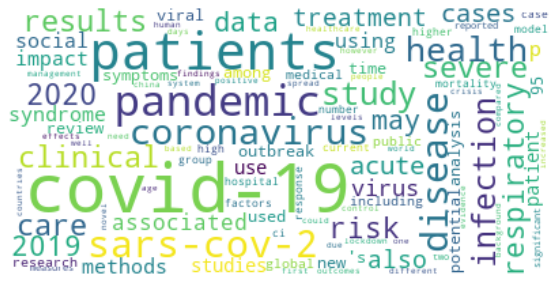

In [136]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(key_freq)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('cloud_all.jpg')
plt.show()

In [137]:
data_1_4 = data_w_date.loc[data_w_date.PD <= '2020-04']
data_5_8 = data_w_date.loc[(data_w_date.PD > '2020-04') & (data_w_date.PD <= '2020-08')]
data_9_12 = data_w_date.loc[(data_w_date.PD > '2020-08') & (data_w_date.PD <= '2020-12')]

cloud_1_4 = data_1_4[['TI','AB']].dropna()
key_freq_1_4 = get_full_keywords(cloud_1_4)
cloud_5_8 = data_5_8[['TI','AB']].dropna()
key_freq_5_8 = get_full_keywords(cloud_5_8)
cloud_9_12 = data_9_12[['TI','AB']].dropna()
key_freq_9_12 = get_full_keywords(cloud_9_12)

In [138]:
wordcloud_1_4 = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(key_freq_1_4)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('cloud_1_4.jpg')
plt.show()

ValueError: ignored

In [ ]:
wordcloud_5_8 = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(key_freq_5_8)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('cloud_5_8.jpg')
plt.show()

In [ ]:
wordcloud_9_12 = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(key_freq_9_12)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('cloud_9_12.jpg')
plt.show()

# Corr

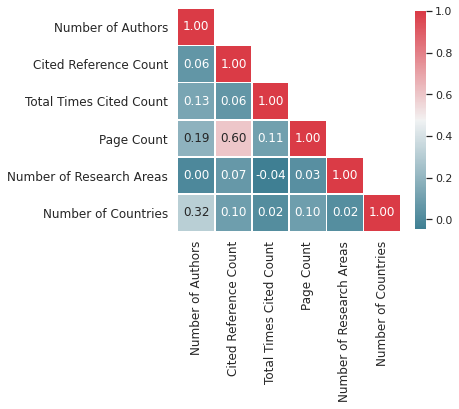

In [140]:
corr_ana = data[['AF', 'NR', 'Z9', 'PG', 'SC', 'C1']].dropna()
corr_ana['Number of Authors']=corr_ana['AF'].str.split(';').apply(lambda x: len(x))
corr_ana['Number of Research Areas']=corr_ana['SC'].str.split(';').apply(lambda x: len(x))
corr_ana['addresses'] = corr_ana['C1'].apply(lambda x: re.sub(r"\[(.*?)\]", "", x).split('; ')).to_list()
country_replace_corr = [[i.replace('North Ireland', 'UK').replace('Wales','UK').replace('Scotland', 'UK').replace('England', 'UK').replace('Czech Republic','Czech') 
for i in x] for x in corr_ana['addresses']]
corr_ana['country_whole']=[list(set(i)) for i in [[j.split()[-1] for j in i] for i in country_replace_corr]]
corr_ana['Number of Countries'] = corr_ana['country_whole'].apply(lambda x: len(x))

corr= corr_ana[['Number of Authors', 'NR', 'Z9', 'PG', 'Number of Research Areas', 'Number of Countries']].rename(
    columns={"NR": "Cited Reference Count", "Z9": "Total Times Cited Count", "PG": "Page Count"}).corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True
sns.set(style="white")

f, ax = plt.subplots(figsize=(5, 5))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,
            square=True, annot=True, fmt = '.2f',
            linewidths=.5, cbar_kws={"shrink": .8}, ax=ax )

locs, labels = plt.yticks();
g.set_yticklabels(labels, rotation=0, size='medium')
locs, labels = plt.xticks();
g.set_xticklabels(labels, rotation=90, size='medium')
plt.savefig('corr.jpg')
plt.show()

# h-, g-index

In [141]:
def h_index(li):
    li_sorted=sorted(li, reverse=True)
    for i in li_sorted:
        if i < li_sorted.index(i)+1:
            break
    return li_sorted.index(i)

def g_index(li):
    li_sorted=sorted(li, reverse=True)
    for i in li_sorted:
        if sum(li_sorted[:li_sorted.index(i)+1])<(li_sorted.index(i)+1)**2:
            break
    return li_sorted.index(i)+1

In [142]:
data_author_index = data[['AF', 'Z9']].dropna()
data_author_index['Authors'] = data_author_index['AF'].str.split(';')
data_author_index_sep = data_author_index.explode('Authors').reset_index().drop(columns=['index','AF'])
data_author_index_sep=data_author_index_sep[['Authors','Z9' ]]
data_h=data_author_index_sep.groupby('Authors').agg(lambda x: list(x)).reset_index()
data_h['h_index']= data_h['Z9'].apply(h_index)
h_index_top10 = data_h.sort_values('h_index',ascending=False).drop(columns='Z9').reset_index(drop=True).head(20)
data_h['g_index']= data_h['Z9'].apply(g_index)
g_index_top10 = data_h.sort_values(['h_index','g_index'],ascending=False).drop(columns='Z9').reset_index(drop=True).head(20)
g_index_top10

,Authors,h_index,g_index
0,"Couloigner, V.",3,4
1,"Rezaei, Nima",2,4
2,"Shahzad, Umer",2,4
3,"Alter, Galit",2,3
4,"Andersen, Hanne",2,3
5,"Atyeo, Caroline",2,3
6,"Baric, Ralph S.",2,3
7,"Barouch, Dan H.",2,3
8,"Barquera, Simon",2,3
9,"Bondzie, Esther A.",2,3


# Deg of collab

In [143]:
colab_month_w_anonymous = data_w_date[['PD', 'AF']].dropna()
colab_month = colab_month_w_anonymous[colab_month_w_anonymous['AF'] !='[Anonymous]']
colab_month[['AF']]=colab_month[['AF']].applymap(list)
colab_month['AF'] = colab_month['AF'].apply(lambda x: ';' in x).astype('int')

colab_month_sep=colab_month.groupby('PD')['AF'].value_counts().rename_axis(['Date','sin/mul']).reset_index(name='Count')
deg_colab_pivot = colab_month_sep.pivot(index='Date', columns='sin/mul', values='Count').fillna(0).reset_index()
deg_colab_pivot['deg_colab']=deg_colab_pivot[1]/(deg_colab_pivot[0]+deg_colab_pivot[1])
deg_colab_pivot

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


sin/mul,Date,0,1,deg_colab
0,2020-06,4,9,0.692308
1,2020-07,1,2,0.666667
2,2020-08,121,778,0.865406
3,2020-09,281,1617,0.851949
4,2020-10,40,293,0.879880
5,2020-11,4,39,0.906977
6,2020-12,19,31,0.620000


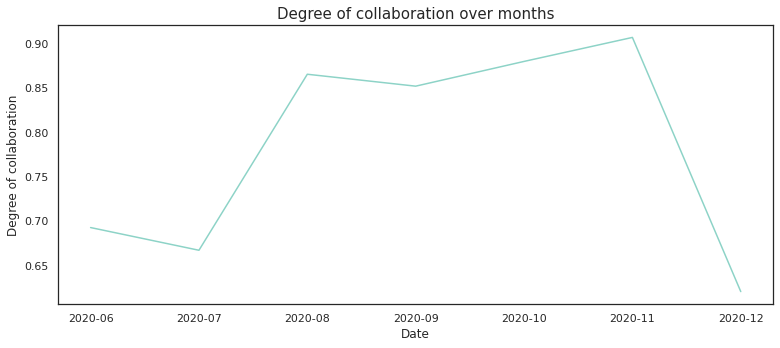

In [144]:
with plt.style.context({'axes.prop_cycle' : plt.cycler('color', plt.cm.Set3.colors)}):
    plt.figure(figsize=(11,5))
    sns.lineplot(x=deg_colab_pivot['Date'], y=deg_colab_pivot['deg_colab'],
            #hue_order=deg_colab_pivot.sort_values(by=['Date'])['Funding'].tolist(),
            palette='Set2')

    plt.xlabel('Date',fontsize=12)
    plt.ylabel('Degree of collaboration',fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.title('Degree of collaboration over months', fontsize=15)
    plt.tight_layout()
    plt.savefig('deg_colab.pdf')
    plt.show()

# International collab & Research area

In [145]:
int_colab = data_w_date[['PD','C1']].dropna()
int_colab['C1'] = int_colab['C1'].apply(lambda x: re.sub(r"\[(.*?)\]", "", x).split('; ')).to_list()
int_colab['country_whole']=[list(set(i)) for i in [[j.split(', ')[-1] for j in i] for i in int_colab['C1']]]
int_colab['replace'] = [[replace(i) for i in j] for j in int_colab['country_whole']]
int_colab['replace'] = [list(set(i)) for i in int_colab['replace']]
int_colab['num_country'] = int_colab['replace'].apply(lambda x: len(x))
int_colab.loc[int_colab['num_country']>1, 'num_country'] = 2
int_colab_counts = int_colab.groupby('PD')['num_country'].value_counts().rename_axis(['date','collab']).reset_index(name='Count').pivot(index='date', columns='collab', values='Count').fillna(0).reset_index()
int_colab_counts['percentage_inter_colab']=int_colab_counts[2]/(int_colab_counts[1]+int_colab_counts[2])
int_colab_counts


collab,date,1,2,percentage_inter_colab
0,2020-06,12.0,0.0,0.000000
1,2020-07,3.0,0.0,0.000000
2,2020-08,623.0,205.0,0.247585
3,2020-09,1411.0,384.0,0.213928
4,2020-10,247.0,80.0,0.244648
5,2020-11,27.0,16.0,0.372093
6,2020-12,37.0,13.0,0.260000


In [146]:
ra_sm = data_w_date[['PD','SC']].dropna()
ra_sm['SC'] = ra_sm['SC'].str.split(';')
ra_sm['cnt'] = ra_sm['SC'].apply(lambda x: len(x))

ra_sm.loc[ra_sm['cnt']>1, 'cnt'] = 2
ra_sm_counts = ra_sm.groupby('PD')['cnt'].value_counts().rename_axis(['date','ra']).reset_index(name='Count').pivot(index='date', columns='ra', values='Count').fillna(0).reset_index()
ra_sm_counts['percentage_multi_disp']=ra_sm_counts[2]/(ra_sm_counts[1]+ra_sm_counts[2])
ra_sm_counts

ra,date,1,2,percentage_multi_disp
0,2020-06,12.0,1.0,0.076923
1,2020-07,3.0,0.0,0.000000
2,2020-08,762.0,143.0,0.158011
3,2020-09,1292.0,628.0,0.327083
4,2020-10,184.0,150.0,0.449102
5,2020-11,9.0,34.0,0.790698
6,2020-12,43.0,7.0,0.140000


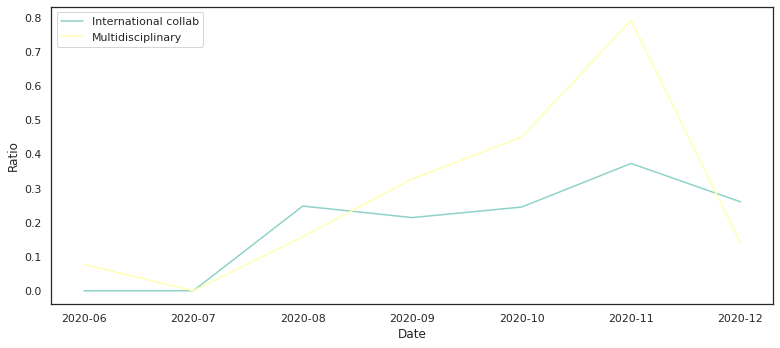

In [147]:
with plt.style.context({'axes.prop_cycle' : plt.cycler('color', plt.cm.Set3.colors)}):
    plt.figure(figsize=(11,5))
    sns.lineplot(x=int_colab_counts['date'], y=int_colab_counts['percentage_inter_colab'], label='International collab')
    sns.lineplot(x=ra_sm_counts['date'], y=ra_sm_counts['percentage_multi_disp'], label='Multidisciplinary')
    plt.xlabel('Date',fontsize=12)
    plt.ylabel('Ratio',fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.legend()
    plt.tight_layout()
    plt.savefig('int_colab_ratio.jpg')
    plt.show()

# summary tb

In [ ]:
sum_tb = data[['SC', 'NR', 'Z9']].dropna().reset_index(drop=True)
sum_tb['SC'] = sum_tb['SC'].str.split(';')
sum_tb_full = sum_tb.explode('SC')
sum_tb_full['cnt']=1
sum_group = sum_tb_full.groupby('SC').sum()
sum_group['Cited Reference Count per']=sum_group['NR']/sum_group['cnt']
sum_group['Times Cited per']=sum_group['Z9']/sum_group['cnt']
sum_group.sort_values(by=['Times Cited per'], ascending=False).head(20)

In [ ]:
sum_country = data[['C1', 'NR', 'Z9']].dropna().reset_index(drop=True)
sum_country['C1'] = sum_country['C1'].apply(lambda x: re.sub(r"\[(.*?)\]", "", x).split('; ')).to_list()
sum_country['country_whole']=[list(set(i)) for i in [[j.split()[-1] for j in i] for i in sum_country['C1']]]                                                      
sum_country_full = sum_country.explode('country_whole').drop(columns='C1')
sum_country_full['num']=1
sum_country_g = sum_country_full.groupby('country_whole').sum()
sum_country_g['Cited Reference Count per'] = sum_country_g['NR']/sum_country_g['num']
sum_country_g['Times Cited per'] = sum_country_g['Z9']/sum_country_g['num']
sum_country_g.sort_values(by=['Times Cited per'], ascending=False).head(20)


# Networkx

In [150]:
def to_network(matrix):
    unik=[]
    for i in matrix:
        for j in i:
            unik.append(j)
    keys=list(set(unik))

    dicti={}
    for key in keys:
        value=[]
        for sublist in matrix:
            if key in sublist:
                li = list(sublist)
                li.remove(key)
                value=value+list(set(li))        
        dicti[key]=value
        
    G = nx.Graph()
    for key, value in dicti.items():
        for i in list(value):
            G.add_edge(key, i, weight = value.count(i))       
    return G

In [151]:
matrix_author = list(data_author['AF'])
matrix_inst = list(data_inst['C1'])
country_mtx_df = list(data_country['replace_1'])
matrix_ra = list(data_research['SC'])

nw_author = to_network(matrix_author)
nw_institute = to_network(matrix_inst)
nw_country = to_network(country_mtx_df)
nw_ra = to_network(matrix_ra)

In [152]:
matrix_kwd = [[i.lower() for i in j ]for j in data_keywords.DE]
nw_kwd = to_network(matrix_kwd)

# Centrality author

In [153]:
def centrality(G):
    largest_cc = max(nx.connected_components(G), key=len)
    S = G.subgraph(largest_cc).copy()   
    bet_cen = nx.betweenness_centrality(S)
    pagerank = nx.pagerank(S)
    betweeness = pd.DataFrame(sorted(bet_cen.items(), key=lambda item: item[1], reverse=True), columns=['Name','betweeness']).reset_index(drop=True)
    pgrk = pd.DataFrame(sorted(pagerank.items(), key=lambda item: item[1], reverse=True), columns=['Name','pagerank']).reset_index(drop=True)
    return pd.merge(betweeness,pgrk,on='Name',how='outer').sort_values(by=['betweeness','pagerank'], ascending=False).head(10)

In [154]:
centrality_au = centrality(nw_author)
centrality_au

,Name,betweeness,pagerank
0,"Liu, Yong",0.349588,0.001259
1,"Chen, Bing",0.217078,0.000417
2,"Wang, Liang",0.171988,0.000415
3,"Wang, Jian",0.150255,0.001412
4,"Gao, Yong",0.127169,0.000914
5,"Li, Yang",0.122494,0.001171
6,"Zhao, Jincun",0.120141,0.000653
7,"Luo, Hong",0.111063,0.000384
8,"Li, Mei",0.108879,0.000445
9,"Baric, Ralph S.",0.106270,0.000548


In [155]:
nx.number_connected_components(nw_author)

3559

In [156]:
[len(c) for c in sorted(nx.connected_components(nw_author), key=len, reverse=True)][:10]

[3578, 294, 249, 178, 166, 118, 102, 98, 96, 96]

In [157]:

largest_au_cc = [c for c in max(nx.connected_components(nw_author), key=len)]
count=0
for i in centrality_au.Name:
  if i in largest_au_cc:
    count+=1
count

10

In [158]:
len(max(nx.connected_components(nw_author), key=len))/len(nw_author)

0.1239649378096525

In [159]:
#check most important authors belong to what communities

# Centrality institute

In [160]:
centrality_inst = centrality(nw_institute)
centrality_inst

,Name,betweeness,pagerank
0,Harvard Med Sch,0.067859,0.004915
1,Univ Oxford,0.052188,0.003293
2,Univ Milan,0.037140,0.002720
3,UCL,0.036892,0.002936
4,Kings Coll London,0.036622,0.002986
5,Univ Toronto,0.035465,0.003462
6,Johns Hopkins Univ,0.033062,0.002428
7,Monash Univ,0.027257,0.002758
8,Univ Padua,0.025104,0.002538
9,Univ Paris,0.024587,0.001892


In [161]:
nx.number_connected_components(nw_institute)

441

In [162]:
[len(c) for c in sorted(nx.connected_components(nw_institute), key=len, reverse=True)][:10]

[5909, 11, 11, 10, 8, 7, 7, 7, 7, 7]

In [163]:
largest_ins_cc = [c for c in max(nx.connected_components(nw_institute), key=len)]
count_ins=0
for i in centrality_inst.Name:
  if i in largest_ins_cc:
    count_ins+=1
count_ins

10

# Centrality country

In [215]:
centrality_country = centrality(nw_country)
centrality_country

,Name,betweeness,pagerank
0,USA,0.134917,0.125459
1,UK,0.096080,0.063718
2,Australia,0.059082,0.032149
3,France,0.043271,0.028395
4,Canada,0.040265,0.030032
5,Brazil,0.036846,0.018063
6,South Africa,0.036691,0.014766
7,Italy,0.035852,0.045535
8,Spain,0.035309,0.027911
9,China,0.033390,0.032965


In [216]:
nx.number_connected_components(nw_country)

1

In [217]:
[len(c) for c in sorted(nx.connected_components(nw_country), key=len, reverse=True)]

[126]

# Co-author

In [167]:
pd.DataFrame(sorted(nw_author.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)[:20])

,0,1,2
0,"Saussez, Sven","Lechien, Jerome R.",{'weight': 5}
1,"Diamond, Michael S.","Chen, Rita E.",{'weight': 5}
2,"Nabi, Ghulam","Khan, Suliman",{'weight': 4}
3,"Picone, Olivier","Vivanti, Alexandre J.",{'weight': 4}
4,"Alter, Galit","Schmidt, Aaron G.",{'weight': 4}
5,"Yu, Jingyou","Dagotto, Gabriel",{'weight': 4}
6,"Yu, Jingyou","Barouch, Dan H.",{'weight': 4}
7,"Dagotto, Gabriel","Barouch, Dan H.",{'weight': 4}
8,"Lippi, Giuseppe","Favaloro, Emmanuel J.",{'weight': 4}
9,"Gasbarrini, Antonio","Ianiro, Gianluca",{'weight': 4}


In [168]:
nx.number_of_edges(nw_author)

170394

In [169]:
nx.number_of_selfloops(nw_author)

7

In [170]:
nx.number_of_nodes(nw_author)

28863

In [171]:
#isolated nodes
len(set([i for j in matrix_author for i in j]))-nx.number_of_nodes(nw_author)

628

# co-occur institutions


In [172]:
pd.DataFrame(sorted(nw_institute.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)[:20])

,0,1,2
0,Huazhong Univ Sci & Technol,Huazhong Univ Sci & Technol,{'weight': 34}
1,Univ Toronto,Univ Toronto,{'weight': 30}
2,Harvard Med Sch,Harvard Med Sch,{'weight': 28}
3,Wuhan Univ,Wuhan Univ,{'weight': 28}
4,Univ Oxford,Univ Oxford,{'weight': 22}
5,Harvard Med Sch,Massachusetts Gen Hosp,{'weight': 19}
6,Icahn Sch Med Mt Sinai,Icahn Sch Med Mt Sinai,{'weight': 19}
7,UCL,UCL,{'weight': 15}
8,Univ Tehran Med Sci,Univ Tehran Med Sci,{'weight': 15}
9,Univ Melbourne,Univ Melbourne,{'weight': 14}


In [173]:
nx.number_of_selfloops(nw_institute)

1366

In [174]:
nx.number_of_edges(nw_institute)

41726

In [175]:
nx.number_of_nodes(nw_institute)

6918

In [176]:
#isolated nodes
len(set([i for j in matrix_inst for i in j]))-nx.number_of_nodes(nw_institute)

403

# node: country

In [177]:
pd.DataFrame(sorted(nw_country.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)[:20])

,0,1,2
0,USA,USA,{'weight': 792}
1,UK,USA,{'weight': 117}
2,Italy,USA,{'weight': 103}
3,USA,China,{'weight': 92}
4,USA,Canada,{'weight': 84}
5,Italy,UK,{'weight': 75}
6,USA,Australia,{'weight': 64}
7,USA,India,{'weight': 54}
8,UK,China,{'weight': 52}
9,France,USA,{'weight': 50}


In [178]:
nx.number_of_selfloops(nw_country)

3

In [179]:
nx.number_of_edges(nw_country)

1667

In [180]:
nx.number_of_nodes(nw_country)

126

In [181]:
len(set([i for j in country_mtx_df for i in j]))-nx.number_of_nodes(nw_country)

10

# co-occurrence of research area

In [182]:
pd.DataFrame(sorted(nw_ra.edges(data=True),key= lambda x: x[2]['weight'],reverse=True))[:20]

,0,1,2
0,Social Sciences - Other Topics,Medical Ethics,{'weight': 60}
1,Hematology,Cardiovascular System & Cardiology,{'weight': 54}
2,Social Issues,Biomedical Social Sciences,{'weight': 52}
3,Social Sciences - Other Topics,Social Issues,{'weight': 51}
4,Social Sciences - Other Topics,Biomedical Social Sciences,{'weight': 50}
5,Infectious Diseases,Immunology,{'weight': 50}
6,Cell Biology,Biochemistry & Molecular Biology,{'weight': 49}
7,Social Issues,Medical Ethics,{'weight': 49}
8,Biomedical Social Sciences,Medical Ethics,{'weight': 49}
9,Psychiatry,Neurosciences & Neurology,{'weight': 46}


In [183]:
nx.number_of_edges(nw_ra)

493

In [184]:
nx.number_of_selfloops(nw_ra)

0

In [185]:
nx.number_connected_components(nw_ra)

1

In [186]:
[len(c) for c in sorted(nx.connected_components(nw_ra), key=len, reverse=True)]

[129]

In [187]:
nx.number_of_nodes(nw_ra)

129

In [188]:
#isolated nodes
len(set([i for j in matrix_ra for i in j]))-nx.number_of_nodes(nw_ra)

8

# author keyword co-occurrence

In [189]:
pd.DataFrame(sorted(nw_kwd.edges(data=True),key= lambda x: x[2]['weight'],reverse=True))[:20]

,0,1,2
0,sars-cov-2,covid-19,{'weight': 568}
1,coronavirus,covid-19,{'weight': 283}
2,covid-19,pandemic,{'weight': 217}
3,sars-cov-2,coronavirus,{'weight': 117}
4,coronavirus,pandemic,{'weight': 65}
5,covid-19,mortality,{'weight': 52}
6,covid-19,anxiety,{'weight': 41}
7,covid-19,depression,{'weight': 39}
8,covid-19,mental health,{'weight': 39}
9,sars-cov-2,pandemic,{'weight': 38}


# small-world

In [211]:
len(max(nx.connected_components(nw_author), key=len))

3578

In [218]:
largest_cc = max(nx.connected_components(nw_author), key=len)
S = nw_author.subgraph(largest_cc).copy()
nx.average_shortest_path_length(S)

7.3324994339183025

In [214]:
import math
math.log(len(max(nx.connected_components(nw_author), key=len)))

8.182559264068665

# Scale-free

In [262]:
degree_sequence = sorted([d for n, d in nw_author.degree()], reverse=True)
len_deg_seq = len(degree_sequence)

In [297]:
deg_occur = []
for i in degree_sequence:
  num = degree_sequence.count(i)
  deg_occur.append(num)

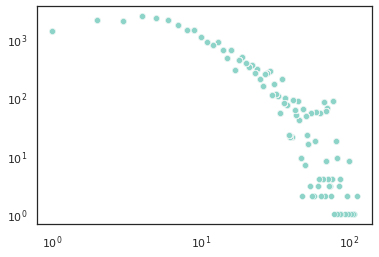

In [298]:
with plt.style.context({'axes.prop_cycle' : plt.cycler('color', plt.cm.Set3.colors)}):
  f, ax = plt.subplots()
  ax.set(xscale="log", yscale="log")
  sns.scatterplot(x=degree_sequence, y=deg_occur, ax=ax)


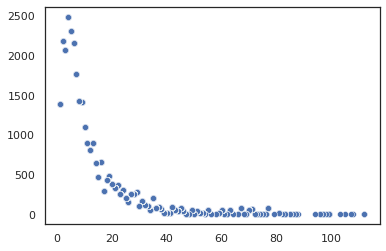

In [294]:
f, ax = plt.subplots()

sns.scatterplot(x=degree_sequence, y=deg_occur)

# assort co-author ntw (double check this section)

In [193]:
sub_nw_author_component = [nw_author.subgraph(c).copy() for c in sorted(nx.connected_components(nw_author), key=len, reverse=True)]
assort_l = []
avg_clustering = []
for k in sub_nw_author_component:
  r = nx.degree_assortativity_coefficient(k)
  clust = nx.average_clustering(k)
  assort_l.append(f"{r:3.1f}")
  avg_clustering.append(clust)

/usr/local/lib/python3.6/dist-packages/networkx/algorithms/assortativity/correlation.py:287: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)


In [194]:
assort = [i.replace('nan', '100') for i in assort_l]
assortativity = [float(i) for i in assort]
weight_au_component_norm = [len(c)/len(nw_author) for c in sorted(nx.connected_components(nw_author), key=len, reverse=True)]
weight_au_component = [len(c) for c in sorted(nx.connected_components(nw_author), key=len, reverse=True)]


In [195]:
assort_non_nan = []
weight_au_component_non_nan = []
for i,j in zip(assortativity, weight_au_component):
  if i!=float(100):
    assort_non_nan.append(i)
    weight_au_component_non_nan.append(j)
print(assort_non_nan)

[0.8, 0.4, 0.7, 0.2, 0.8, 0.8, 0.8, 0.3, 0.4, 0.7, 0.8, 0.4, 0.4, 0.8, 0.3, 0.4, 0.3, 0.1, 0.0, 0.4, 0.8, 0.2, 0.3, 0.3, 0.5, -0.0, 0.4, 0.7, 0.1, 0.4, 0.4, 0.9, -0.0, 0.6, 0.7, 0.3, 0.7, 0.7, 0.5, 0.2, 0.9, 0.7, -0.1, 0.1, 0.5, 0.2, -0.0, 0.1, 0.5, 0.6, 0.3, 0.9, 0.5, -0.1, 0.6, 0.7, 0.3, 0.3, -0.1, 0.8, 0.1, 0.3, -0.1, 0.1, 0.3, -0.1, -0.2, 0.4, 0.4, 0.7, 0.3, 0.5, 0.2, 0.5, 0.3, -0.2, 0.5, 0.3, 0.3, 0.3, -0.1, 0.5, -0.2, -0.1, 0.3, 0.4, 0.4, -0.0, -0.1, 0.3, -0.2, 0.6, 0.6, 0.1, 0.4, 0.1, 0.4, 0.4, 0.3, 0.1, 0.2, -0.1, -0.2, -0.3, 0.2, -0.1, -0.1, -0.0, 0.0, -0.0, 0.5, 0.5, 0.4, 0.4, 0.5, 0.0, 0.1, -0.1, 0.2, -0.0, 0.4, -0.1, 0.3, 0.5, 0.5, 0.4, 0.3, 0.5, 0.1, -0.1, -0.2, 0.0, 0.1, -0.1, 0.4, -0.2, -0.3, -0.1, 0.2, 0.0, -0.2, 0.4, 0.3, 0.1, 0.2, 0.2, 0.3, -0.0, -0.2, 0.4, 0.1, -0.0, -0.1, -0.2, -0.2, 0.3, -0.1, -0.3, 0.1, -0.0, -0.2, 0.1, 0.0, -0.1, -0.2, -0.2, 0.2, -0.0, 0.3, 0.3, -0.2, -0.2, -0.3, 0.3, 0.1, -0.2, 0.3, -0.2, -0.2, 0.0, -0.2, -0.2, 0.2, -0.2, 0.1, -0.1, -0.1, -0.2, 

In [196]:
print(weight_au_component_non_nan[-11:])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [197]:
print(assort_non_nan[-20:])
#component

[-0.5, -0.6, -0.6, -0.6, -0.7, -0.7, -0.7, -0.7, -0.7, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


In [198]:
len(assort_non_nan)

379

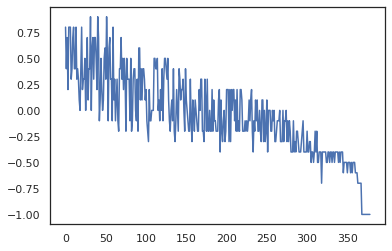

In [199]:
plt.plot(assort_non_nan)

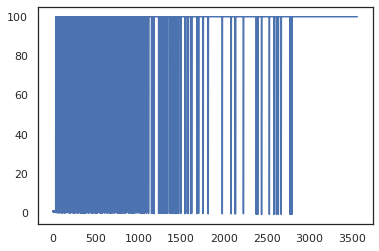

In [200]:
plt.plot(assortativity)
#change 100 to 0 in the above cell

In [201]:
sum(weight_au_component_non_nan)

11776

In [202]:
#removing nan assortativity components. weighted avg
product_1=[]
for i,j in zip(assort_non_nan, weight_au_component_non_nan):
  product_1.append(i*j/sum(weight_au_component_non_nan))
sum(product_1)

0.39871773097826324

In [203]:
sum(assort_non_nan)/len(assort_non_nan)

-0.04643799472295521

# clustering co-au

In [204]:
nx.average_clustering(nw_author)
#this is correct (local)

0.9311909256197883